In [45]:
import pickle
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
sys.path.append("../lib")
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

In [2]:
with open('../results/det_results_seedling_jpg_1.pkl', 'rb') as fin:
    det_results_oi = pickle.load(fin)

In [3]:
with open('../results/det_results_seedling_jpg_2.pkl', 'rb') as fin:
    det_results_coco = pickle.load(fin)

In [4]:
with open('../temp/norm_coef_1.pkl', 'rb') as fin:
    norm_coefs = pickle.load(fin)

In [5]:
with open('../temp/label_matching_coco_oi.pkl', 'rb') as fin:
    label_matching_meta = pickle.load(fin)

In [15]:
idx2mid_oi = label_matching_meta['idx2mid_oi']
idx2mid_coco = label_matching_meta['idx2mid_coco']
mid2idx_oi = label_matching_meta['mid2idx_oi']
mid2idx_coco = label_matching_meta['mid2idx_coco']
mid2name_oi = label_matching_meta['mid2name_oi']
mid2name_coco = label_matching_meta['mid2name_coco']

mid2name_combined = {}
for key in mid2name_coco:
    mid2name_combined[key] = mid2name_coco[key]
for key in mid2name_oi:
    mid2name_combined[key] = mid2name_oi[key]
    
idx2mid = list(mid2name_combined.keys())
mid2idx = {mid: i for i, mid in enumerate(idx2mid)}

category_index = {mid2idx[key]:{'id': mid2idx[key], 'name': mid2name_combined[key]} for key in mid2name_combined}

In [7]:
def iou(det_bbox, gt_bbox):
    x_d_len = det_bbox[2] - det_bbox[0]
    y_d_len = det_bbox[3] - det_bbox[1]
    x_t_len = gt_bbox[2] - gt_bbox[0]
    y_t_len = gt_bbox[3] - gt_bbox[1]
    x_int_len = max(0, min(gt_bbox[2], det_bbox[2]) - max(gt_bbox[0], det_bbox[0]))
    y_int_len = max(0, min(gt_bbox[3], det_bbox[3]) - max(gt_bbox[1], det_bbox[1]))
    iou = (x_int_len*y_int_len) / (x_d_len*y_d_len + x_t_len*y_t_len - x_int_len*y_int_len)
    return iou

In [11]:
iou_thresh_same = 0.5
iou_thresh_diff = 0.7

det_results_combined = {}
for imgid in det_results_oi:
    merged_coco = set()
    det_results_combined[imgid] = []
    
    for ii in range(det_results_oi[imgid]['num_detections']):
        det_label_oi = idx2mid_oi.get(det_results_oi[imgid]['detection_classes'][ii])
        det_bbox_oi = det_results_oi[imgid]['detection_boxes'][ii]
        det_score_oi = det_results_oi[imgid]['detection_scores'][ii]
        if det_score_oi == 0.:
            continue
        
        det_score_oi_comp_coco = (((det_score_oi - norm_coefs[det_label_oi]['mean_oi']) 
                                   * norm_coefs[det_label_oi]['std_coco'] / norm_coefs[det_label_oi]['std_oi'] 
                                   + norm_coefs[det_label_oi]['mean_coco']) 
                                  if det_label_oi in norm_coefs else (
                                   ((det_score_oi - norm_coefs['default']['mean_oi']) 
                                   * norm_coefs['default']['std_coco'] / norm_coefs['default']['std_oi'] 
                                   + norm_coefs['default']['mean_coco']) 
                                 ))
        
        match = []        
        flag = False
        
        for iii in range(det_results_coco[imgid]['num_detections']):
            det_label_coco = idx2mid_coco.get(det_results_coco[imgid]['detection_classes'][iii])
            det_bbox_coco = det_results_coco[imgid]['detection_boxes'][iii]
            det_score_coco = det_results_coco[imgid]['detection_scores'][iii]
            if det_score_coco == 0.:
                continue

            if det_label_oi == det_label_coco:
                if iou(det_bbox_oi, det_bbox_coco) >= iou_thresh_same:
                    if iii in merged_coco:
                        flag = True
                        break
                    match.append(iii)
                    merged_coco.add(iii)

            else:
                if iou(det_bbox_oi, det_bbox_coco) >= iou_thresh_diff:
                    if det_score_coco > det_score_oi_comp_coco:
                        flag = True
                        break
                    else:
                        merged_coco.add(iii)
                    
        if flag:
            continue
            
        if len(match) > 0:
            new_bbox = np.asarray([
                min([det_results_coco[imgid]['detection_boxes'][iii][0] for iii in match] + [det_bbox_oi[0]]),
                min([det_results_coco[imgid]['detection_boxes'][iii][1] for iii in match] + [det_bbox_oi[1]]),
                max([det_results_coco[imgid]['detection_boxes'][iii][2] for iii in match] + [det_bbox_oi[2]]),
                max([det_results_coco[imgid]['detection_boxes'][iii][3] for iii in match] + [det_bbox_oi[3]]),
            ])

            new_score = (sum([det_results_coco[imgid]['detection_scores'][iii] for iii in match]) + det_score_oi_comp_coco) / (len(match) + 1)
            new_score = min(max(new_score, 0.), 1.)

            det_results_combined[imgid].append({'detection_class': det_label_oi, 
                                                'detection_box': new_bbox, 
                                                'detection_score': new_score, 
                                                'detection_model': 'joint'})
        else:
            det_results_combined[imgid].append({'detection_class': det_label_oi, 
                                                'detection_box': det_bbox_oi, 
                                                'detection_score': det_score_oi_comp_coco, 
                                                'detection_model': 'oi'})
            
    for iii in set(range(det_results_coco[imgid]['num_detections'])) - merged_coco:
        det_label_coco = idx2mid_coco.get(det_results_coco[imgid]['detection_classes'][iii])
        det_bbox_coco = det_results_coco[imgid]['detection_boxes'][iii]
        det_score_coco = det_results_coco[imgid]['detection_scores'][iii]
        if det_score_coco == 0.:
            continue
        det_results_combined[imgid].append({'detection_class': det_label_coco, 
                                            'detection_box': det_bbox_coco, 
                                            'detection_score': det_score_coco, 
                                            'detection_model': 'coco'})



In [12]:
det_results_combined_2 = {}
for key, value in det_results_combined.items():
    neg_probs = [-val['detection_score'] for val in value]
    sort_idx = np.argsort(neg_probs)
    det_results_combined_2[key] = {'detection_classes': [], 'detection_boxes': [], 'detection_scores': [], 'detection_models': []}
    for i in sort_idx:
        det_results_combined_2[key]['detection_classes'].append(value[i]['detection_class'])
        det_results_combined_2[key]['detection_boxes'].append(value[i]['detection_box'])
        det_results_combined_2[key]['detection_scores'].append(value[i]['detection_score'])
        det_results_combined_2[key]['detection_models'].append(value[i]['detection_model'])
    det_results_combined_2[key]['num_detections'] = len(sort_idx)
    
    

In [13]:
with open('../results/det_results_combined_seedling_jpg_1.pkl', 'wb') as fout:
    pickle.dump(det_results_combined_2, fout)

In [17]:
det_results = det_results_combined_2

In [18]:
for key in det_results:
    for i in range(len(det_results[key]['detection_classes'])):
        det_results[key]['detection_classes'][i] = mid2idx.get(det_results[key]['detection_classes'][i], 0)

In [32]:
def preproc(im):
    target_size = 400
    max_size = 1024
    im_size_min = np.min(im.shape[0:2])
    im_size_max = np.max(im.shape[0:2])
    im_scale = float(target_size) / float(im_size_min)
    # Prevent the biggest axis from being more than MAX_SIZE
    if np.round(im_scale * im_size_max) > max_size:
        im_scale = float(max_size) / float(im_size_max)
    im = cv2.resize(im, None, None, fx=im_scale, fy=im_scale,
                    interpolation=cv2.INTER_LINEAR)    
    return im

/home/alireza/home_at_filer2/tools/anaconda3/envs/py3tf/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


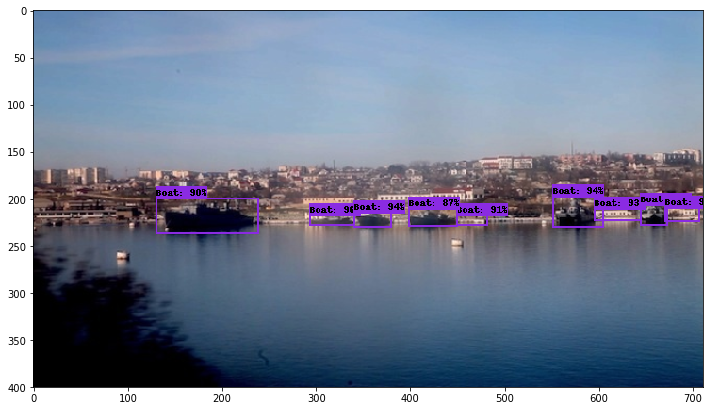

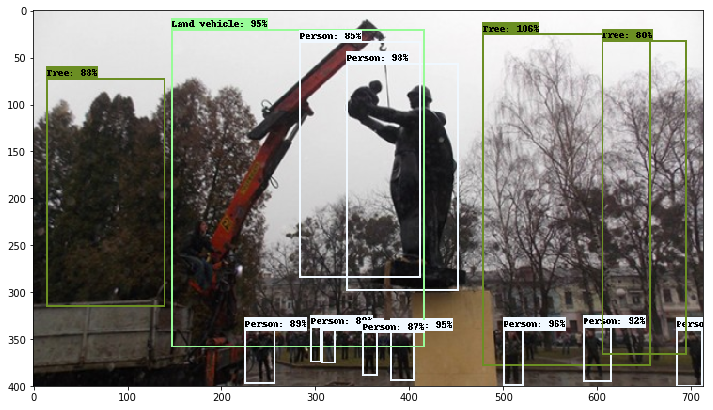

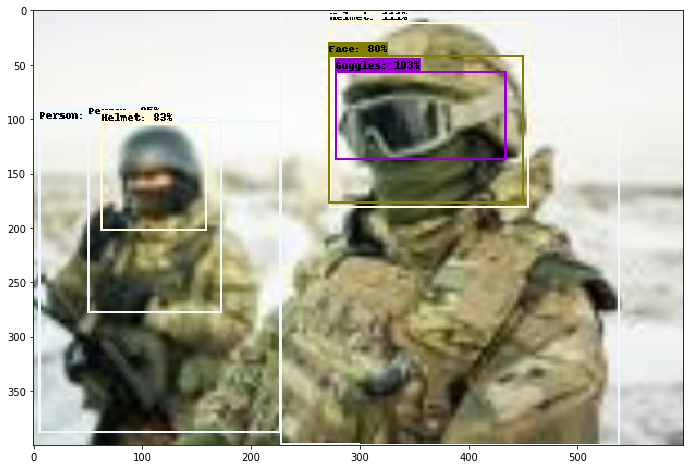

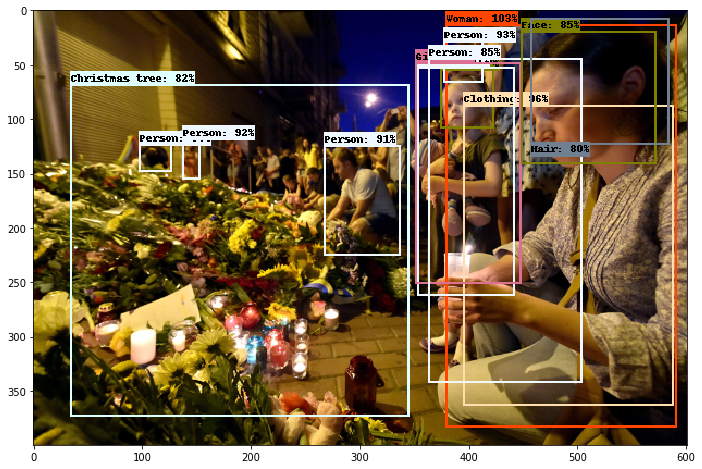

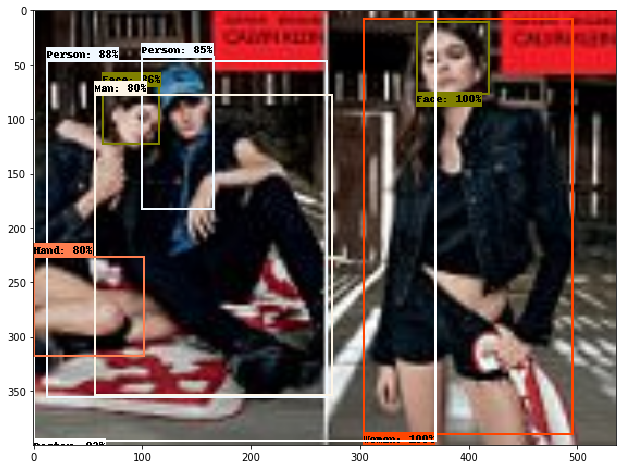

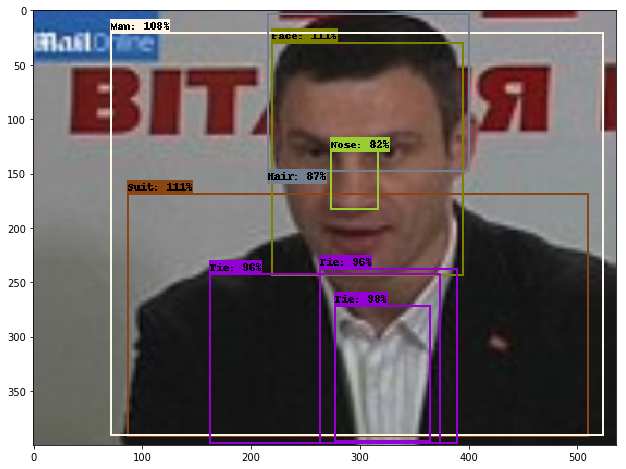

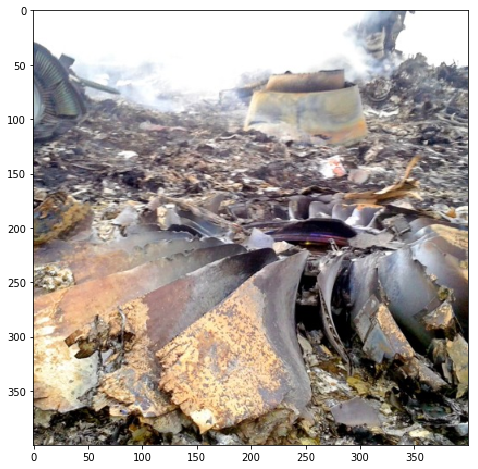

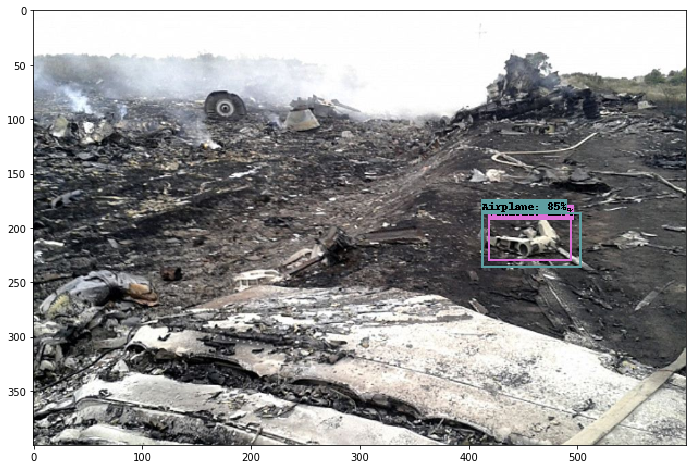

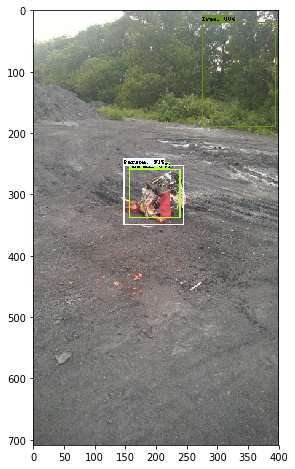

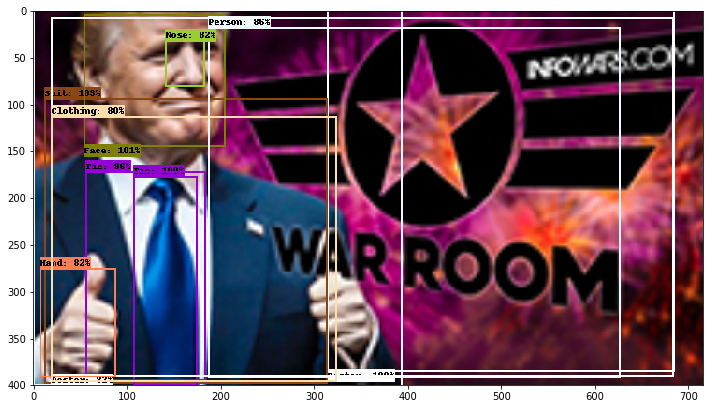

In [48]:
for _ in range(10):
    imgid = np.random.choice(list(det_results.keys()))
    filename = '../../data/seedling/jpg/' + imgid
    with open(filename, 'rb') as fin:
        _ = fin.read(1024)
        imgbin = fin.read()
    imgbgr = cv2.imdecode(np.fromstring(imgbin, dtype='uint8'), cv2.IMREAD_COLOR)
    image_np = imgbgr[:,:,[2,1,0]]
    image_np = preproc(image_np)
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      np.asarray(det_results[imgid]['detection_boxes']),
      det_results[imgid]['detection_classes'],
      det_results[imgid]['detection_scores'],
      category_index,
      instance_masks=det_results[imgid].get('detection_masks'),
      use_normalized_coordinates=True,
      min_score_thresh=0.8,
      line_thickness=2)
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)
    plt.show()